# PROJEKT MODELU KLASYFIKACYJNEGO PRZEWIDYWANIA STANU MIESZKAŃ NA PODSTAWIE #

## Extra Trees Classifier ##

### kwiecień 2025

In [1]:
import pandas as pd
from pycaret.classification import setup, pull, compare_models, plot_model
from sklearn.feature_extraction.text import CountVectorizer
import pymysql
from sqlalchemy import create_engine
import numpy as np
from scipy.stats import skewnorm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# tą komórkę uruchom jeżeli bazę danych bierzesz np. z DBeaver, oracle developer itp.
username = 'root'
password = '1234'
host = '127.0.0.1'
port = 3306  
database = 'projekt1'
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

df = pd.read_sql("SELECT * FROM saleflats", con=engine)

engine.dispose()

In [2]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df = pd.read_csv('saleflats_3.csv', sep=',')

In [3]:
df

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,1509,NaN,3,2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji,2-pokojowe mieszkanie numer 117 na parterze w ...,50.55,667710.0,NaN,NaN,692985.0,...,NaN,"Mazowieckie, Warszawa, Białołęka, Ul. Marywilska",14,65,3.0,8.0,988796.0,NaN,12437.0,l3VCdQiugvec9flbAdBrbQ==
1,47402,NaN,18,"Mieszkanie na sprzedaż, 37 m2, Warszawa",Bardzo oryginalne mieszkanie w kameralnej kami...,37.00,900000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Karmel...",14,65,10.0,8.0,919810.0,NaN,8061.0,m4Br1ORhqnYW0UlcXOvBa71cwColzIKnjrh_K5zWcDs=
2,47635,NaN,3,Na Cele Biurowe | Parking | Klimatyzacja,PRZESTRONNE MIESZKANIE W ŚCISŁYM CENTRUM Miesz...,197.46,3700000.0,NaN,NaN,3500000.0,...,NaN,"Mazowieckie, Warszawa, Śródmieście, Ul. Grzybo...",14,65,10.0,8.0,919810.0,NaN,6344.0,LPHQ51Dxz80rSSGoAEN28r1cwColzIKnjrh_K5zWcDs=
3,49614,NaN,17,"Apartament, ul. Kasprzaka",Opiekun oferty Bartosz Biernacki tel. Rozkłado...,90.20,2074600.0,NaN,NaN,1885000.0,...,NaN,"Mazowieckie, Warszawa, Wola, Ul. Marcina Kaspr...",14,65,18.0,8.0,919884.0,NaN,8157.0,xZ_mo7ajyPpIfq4TJUMdKb1cwColzIKnjrh_K5zWcDs=
4,50256,NaN,17,"Apartament, ul. Mikołajczyka","Na sprzedaż jasne, przestronne mieszkanie o po...",69.00,1275000.0,NaN,NaN,950000.0,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Sta...",14,65,7.0,8.0,918838.0,NaN,12893.0,rFQ7EkW3EX-L-xrSCpUFor1cwColzIKnjrh_K5zWcDs=
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104577,4347957,NaN,22,"Warszawa/Żoliborz/Braci Załuskich 60m2, 3 pokoje.",OGŁOSZENIE BEZPOŚREDNIE - BEZ PROWIZJI Rozkład...,60.00,849000.0,1043500.00,1322333.33,NaN,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6imrEJkU2QT-yp-az_9WBzEQ=
104578,4347959,NaN,2,2 pokoje odświeżone + piwnica,"Na sprzedaż odświeżone mieszkanie o pow. 36,5 ...",36.50,620000.0,629000.00,651666.67,NaN,...,NaN,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Stru...",14,65,17.0,8.0,918749.0,NaN,21305.0,BLxGC0CEa9Im6gZI5Sf6igAQzbPZDnsbuGvFGXpz1mg=
104579,4347996,NaN,2,Wysokie rabaty i bonusy! Metro SKM Infrastruktura,Nowoczesna architektura Kompaktowe mieszkania ...,60.01,775286.0,782389.08,875268.63,NaN,...,NaN,"Mazowieckie, Warszawa, Ursus",14,65,12.0,8.0,NaN,NaN,NaN,BLxGC0CEa9Im6gZI5Sf6ino5Kb4ifgjNFRUWvwErVL0=
104580,4348007,NaN,38,Klimatyczne mieszkanie Na Nowym Mieście,Oferta aktualna - możliwość umówienia bezpiecz...,52.00,1560800.0,1499000.00,1579933.33,NaN,...,NaN,"Mazowieckie, Warszawa, Śródmieście",14,65,10.0,8.0,NaN,NaN,NaN,B1x1I_JlXpUOXuu-8rye0ixEZaoqZA0WSjJKH4A5guQ=


In [4]:
# pobranie próbki 10 losowych wierszy
df.sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
38922,3100665,NaN,38,3 pokoje | Rembertów | 2 balkony | przy lesie,Oferta aktualna - możliwość umówienia bezpiecz...,71.00,990000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Rembertów",14,65,9.0,8.0,NaN,NaN,NaN,h2usZ97IR8HEDXBA5j9bhyykkO2XD8llNorSA-9-Byw=
7365,1772889,NaN,32,Mieszkanie Warszawa gm. Praga-Północ Praga-Pół...,MDP Partners prezentuje: Przestronne trzypokoj...,60.00,1064759.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa",14,65,NaN,NaN,NaN,NaN,NaN,rCjKdLaZGr4Yn3ucetRNbxhr0WkApuPzxhJg57rv_OE=
93330,4200655,NaN,11,"Mieszkanie, Warszawa, Mokotów, 67 m²","Mieszkanie, Warszawa, Mokotów, 67 m² Ogłoszeni...",66.78,1670000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Mokotów",14,65,5.0,8.0,NaN,NaN,NaN,zLyZp7zMNpNTMVpVCPX3TNMxyng9CIZwGm6YVx0bWSY=
94640,4218684,NaN,3,Przytulna Kawalerka⭐Blisko Park | Zielone Osiedle,IDEALNE mieszkanie 1-pokojowe na start w pożąd...,24.50,465000.0,490000.0,621666.67,NaN,...,NaN,"Mazowieckie, Warszawa, Wola, Ulrychów, Ul. Józ...",14,65,18.0,8.0,920025.0,NaN,20629.0,w4X8zpsPXMdn3ylcGTPFW44lcJSA8OB9lFvDEJq2Tpw=
56474,3423860,NaN,3,Przestronne 2 pokoje 58 m2 z balkonem,Sprzedam prywatnie 2-pokojowe mieszkanie o pow...,58.60,878000.0,NaN,NaN,888000.0,...,NaN,"Mazowieckie, Warszawa, Bemowo, Ul. Powstańców ...",14,65,2.0,8.0,988780.0,NaN,17366.0,NSMjtZIXBskOUesCjrMWiTMbFhDt8yVDGT6Er2r0AmA=
1981,1551140,NaN,3,2 pok. 27m2 || Metro Rondo Onz - ul.Krochmalna ||,Na sprzedaż 2 pokojowe mieszkanie usytuowane n...,27.00,585000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wola, Mirów",14,65,18.0,8.0,919967.0,NaN,NaN,ACtTCSGFpoWz40NPhqqozu7YjVk_597D3gSimczV9ho=
79811,3940131,NaN,11,"Mieszkanie, Warszawa, Wola, 74 m²","Mieszkanie, Warszawa, Wola, 74 m² Ogłoszenioda...",74.15,12990000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Wola",14,65,18.0,8.0,NaN,NaN,NaN,wRVB7W7O-EHOplNP1a-Jq0m9CVG6yYs9U2KBME0Psic=
94879,4221811,NaN,3,Kawalerka Do Wprowadzenia | Ch Westfield Mokotów,"Na sprzedaż atrakcyjne, w pełni wyposażone i u...",29.00,540000.0,542500.0,569000.00,NaN,...,NaN,"Mazowieckie, Warszawa, Mokotów, Wyględów, Ul. ...",14,65,5.0,8.0,1067701.0,NaN,12029.0,8H9x2bNRYzM-lK6b9SGnIjWmUtPnej93PX-hxAZ282k=
43396,3181583,NaN,14,Mieszkanie dwupokojowe na sprzedaż,Sprzedam atrakcyjne 2-pokojowe mieszkanie z ba...,41.00,795000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Włochy",14,65,17.0,8.0,NaN,NaN,NaN,sYasvZPCHQeoj-P6dujbdMc0fBXCdCR2219soBArV2g=
47412,3258271,NaN,18,"3 pokoje, balkon, Metro Kabaty","Przestronne, jasne i ciche mieszkanie tuż przy...",77.85,1329000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Ursynów, Ul. Wąwozowa",14,65,13.0,8.0,988833.0,NaN,23810.0,EeNP9SrumIsLkJF81eX-TnAQGFSZzeA3-gwVhOeGLN0=


In [5]:
print(df.columns)

Index(['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area',
       'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice',
       'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type',
       'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors',
       'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded',
       'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom',
       'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates',
       'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower',
       'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore',
       'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
       'Location', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber',
       'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber',
       'EncryptedId'],
      dtype='object')


In [6]:
df['BuiltYear'] = pd.to_datetime(df['BuiltYear'], format='%Y', errors='coerce')

In [7]:
setup(
    data=df,
    target='BuildingCondition',
    session_id=1123,
    categorical_features=['BuildingType', 'Location'],
    date_features=['BuiltYear'],
    ordinal_features={
        'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
    },
    verbose=False
)

In [7]:
df_a = df.dropna(subset=['Description'])

In [8]:
df_a.isnull().sum()

SaleId                            0
OriginalId                   104499
PortalId                          0
Title                             0
Description                       0
Area                            220
Price                          7155
OfferPrice                    95585
RealPriceAfterRenovation      95585
OriginalPrice                 90461
PricePerSquareMeter            7521
NumberOfRooms                  1766
BuiltYear                     14163
Type                              0
BuildingType                  25249
BuildingCondition             97979
OfferFrom                      1389
Floor                          3382
Floors                        17816
TypeOfMarket                   1666
OwnerType                     47977
DateAddedToDatabase               0
DateAdded                         0
DateLastModification          75469
DateLastRaises                64312
NewestDate                        0
AvailableFrom                104499
Link                        

In [9]:
df_b = df_a.dropna(subset=['Location'])

In [10]:
df_b.isnull().sum()

SaleId                            0
OriginalId                   104499
PortalId                          0
Title                             0
Description                       0
Area                            220
Price                          7155
OfferPrice                    95585
RealPriceAfterRenovation      95585
OriginalPrice                 90461
PricePerSquareMeter            7521
NumberOfRooms                  1766
BuiltYear                     14163
Type                              0
BuildingType                  25249
BuildingCondition             97979
OfferFrom                      1389
Floor                          3382
Floors                        17816
TypeOfMarket                   1666
OwnerType                     47977
DateAddedToDatabase               0
DateAdded                         0
DateLastModification          75469
DateLastRaises                64312
NewestDate                        0
AvailableFrom                104499
Link                        

In [11]:
df_b['Description'] = df_b['Description'].str.slice(0, 200)

In [12]:
# Przygotuj wektorizer z limitem
vectorizer = CountVectorizer(max_features=500)  # np. 500 najczęstszych słów
X_bow = vectorizer.fit_transform(df_b["Description"])

# Konwertuj do DataFrame
df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())

# Dołącz do oryginalnych danych (z wyjątkiem kolumny Description)
df_b = df_b.drop(columns=['Description']).reset_index(drop=True)
df_bow = df_bow.reset_index(drop=True)
df_prepared = pd.concat([df_b, df_bow], axis=1)

In [13]:
exp = setup(
    data=df_prepared,
    target='BuildingCondition',
    session_id=1123,
    categorical_features=['BuildingType', 'Location'],
    keep_features=['Description'],
    date_features=['BuiltYear'],
    ordinal_features={
        'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
    },
    verbose=False
)
exp.dataset_transformed.sample(10)

ValueError: 97979 missing values found in the target column: BuildingCondition. To proceed, remove the respective rows from the data. 

In [14]:
df_prepared.info

<bound method DataFrame.info of          SaleId  OriginalId  PortalId  \
0          1509         NaN         3   
1         47402         NaN        18   
2         47635         NaN         3   
3         49614         NaN        17   
4         50256         NaN        17   
...         ...         ...       ...   
104494  4347957         NaN        22   
104495  4347959         NaN         2   
104496  4347996         NaN         2   
104497  4348007         NaN        38   
104498  4348020         NaN        19   

                                                    Title    Area      Price  \
0       2-pokojowe mieszkanie 50m2 + ogródek Bez Prowizji   50.55   667710.0   
1                 Mieszkanie na sprzedaż, 37 m2, Warszawa   37.00   900000.0   
2                Na Cele Biurowe | Parking | Klimatyzacja  197.46  3700000.0   
3                               Apartament, ul. Kasprzaka   90.20  2074600.0   
4                            Apartament, ul. Mikołajczyka   69.00  1275000.

In [15]:
df_prepared[df_prepared.duplicated()]

,SaleId,OriginalId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,...,łazienka,łazienki,łączy,śródmieście,śródmieściu,świetna,świetnej,żoliborz,żoliborzu,życia


In [16]:
df_prepared.nunique()

SaleId        104499
OriginalId         0
PortalId          16
Title          58698
Area            7683
               ...  
świetna            3
świetnej           2
żoliborz           4
żoliborzu          3
życia              3
Length: 550, dtype: int64

In [17]:
df_prepared.isnull()

,SaleId,OriginalId,PortalId,Title,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,PricePerSquareMeter,...,łazienka,łazienki,łączy,śródmieście,śródmieściu,świetna,świetnej,żoliborz,żoliborzu,życia
0,False,True,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,True,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,True,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104494,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
104495,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
104496,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
104497,False,True,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


In [18]:
df_prepared.isnull().sum()

SaleId             0
OriginalId    104499
PortalId           0
Title              0
Area             220
               ...  
świetna            0
świetnej           0
żoliborz           0
żoliborzu          0
życia              0
Length: 550, dtype: int64

In [19]:
Q1 = df_prepared["Price"].quantile(0.25)
Q3 = df_prepared["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prep_p = df_prepared[~((df_prepared["Price"] < lower_bound) | (df_prepared["Price"] > upper_bound))]

In [20]:
Q1 = df_prep_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_prep_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prep_a = df_prep_p[~((df_prep_p["PricePerSquareMeter"] < lower_bound) | (df_prep_p["PricePerSquareMeter"] > upper_bound))]

In [21]:
Q1 = df_prep_a["Area"].quantile(0.25)
Q3 = df_prep_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prepared2 = df_prep_a[~((df_prep_a["Area"] < lower_bound) | (df_prep_a["Area"] > upper_bound))]

In [22]:
df_prepared2["BuildingCondition"].value_counts(normalize=True)

BuildingCondition
DEVELOPER_STATE     0.407755
AFTER_RENOVATION    0.404104
FOR_RENOVATION      0.101374
GOOD                0.086768
Name: proportion, dtype: float64

In [23]:
df_prepared2.nunique()

SaleId        91538
OriginalId        0
PortalId         16
Title         51010
Area           5960
              ...  
świetna           3
świetnej          2
żoliborz          3
żoliborzu         3
życia             3
Length: 550, dtype: int64

In [24]:
unique_btype=df_prepared2['BuildingType'].unique()

unique_btype

array([nan, 'Kamienica', 'Apartamentowiec', 'Blok', 'Pozostałe'],
      dtype=object)

In [25]:
print(df_prepared2['BuildingCondition'].nunique())

4


In [26]:
unique_ctype=df_prepared2['BuildingCondition'].unique()

unique_ctype

array([nan, 'DEVELOPER_STATE', 'AFTER_RENOVATION', 'GOOD',
       'FOR_RENOVATION'], dtype=object)

In [27]:
df_prepared2.isnull().sum()

SaleId            0
OriginalId    91538
PortalId          0
Title             0
Area            211
              ...  
świetna           0
świetnej          0
żoliborz          0
żoliborzu         0
życia             0
Length: 550, dtype: int64

In [30]:
df_prepared3=df_prepared2.dropna(subset=['BuildingCondition'])

In [31]:
unbalanced_exp = setup(
    data=df_prepared3,
    target='BuildingCondition',
    session_id=1123,
    categorical_features=['BuildingType', 'Location'],
    date_features=['BuiltYear'],
    ordinal_features={
        'BuildingType': ['Pozostałe', 'Blok', 'Apartametowiec', 'Kamienica']
    },
    verbose=False,

    ignore_features=[
        'SaleId',
        'RealPriceAfterRenovation',
        'OfferPrice',
        'OriginalPrice',
        'PricePerSquareMeter',
        'OriginalId',
        'PortalId',
        'Title',
        'Type',
        'OfferFrom',
        'TypeOfMarket',
        'OwnerType',
        'DateAddedToDatabase',
        'DateAdded',
        'DateLastModification',
        'DateLastRaises',
        'NewestDate',
        'AvailableFrom',
        'Link',
        'Phone',
        'MainImage',
        'OtherImages',
        'NumberOfDuplicates',
        'NumberOfRaises',
        'NumberOfModifications',
        'IsDuplicatePriceLower',
        'IsDuplicatePrivateOwner',
        'Score',
        'ScorePrecision',
        'CommunityScore',
        'NumberOfCommunityComments',
        'NumberOfCommunityOpinions',
        'Archive',
        'VoivodeshipNumber',
        'CountyNumber',
        'CommunityNumber',
        'RegionNumber',
        'KindNumber',
        'SubRegionNumber',
        'StreetNumber',
        'EncryptedId',
        ],
         
       
)
best_unbalanced_model = unbalanced_exp.compare_models()
unbalanced_metrics_df = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7936,0.9116,0.7936,0.7849,0.7618,0.6632,0.6820,0.1590
rf,Random Forest Classifier,0.7876,0.9054,0.7876,0.7792,0.7529,0.6525,0.6719,0.1510
lightgbm,Light Gradient Boosting Machine,0.7630,0.8989,0.7630,0.7390,0.7456,0.6248,0.6291,0.7120
ridge,Ridge Classifier,0.7481,0.0000,0.7481,0.7158,0.7208,0.5941,0.6024,0.0920
gbc,Gradient Boosting Classifier,0.7473,0.0000,0.7473,0.7143,0.7237,0.5959,0.6014,0.9780
lda,Linear Discriminant Analysis,0.7329,0.0000,0.7329,0.7261,0.7279,0.5850,0.5863,0.1180
ada,Ada Boost Classifier,0.6967,0.0000,0.6967,0.6665,0.6765,0.5175,0.5215,0.2270
dt,Decision Tree Classifier,0.6904,0.7735,0.6904,0.6758,0.6821,0.5195,0.5202,0.3800
lr,Logistic Regression,0.6902,0.0000,0.6902,0.6342,0.6430,0.4915,0.5046,1.3750
knn,K Neighbors Classifier,0.6084,0.7629,0.6084,0.5931,0.5787,0.3652,0.3795,0.3910


Processing:   0%|          | 0/61 [00:00<?, ?it/s]

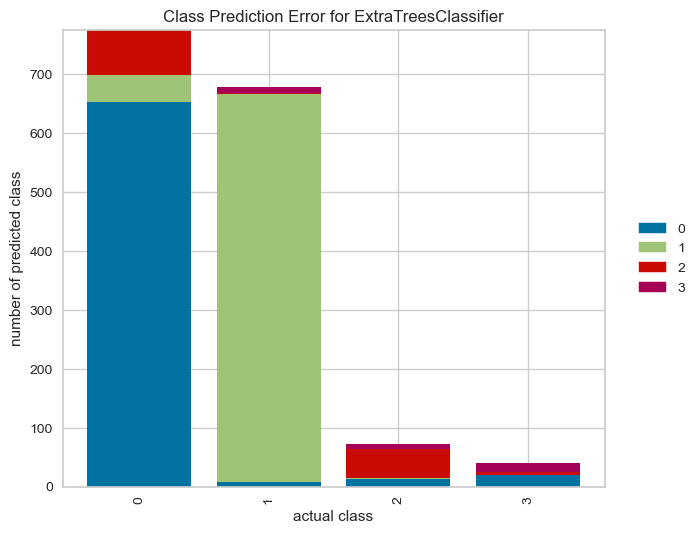

In [33]:
unbalanced_exp.plot_model(best_unbalanced_model, plot='error')

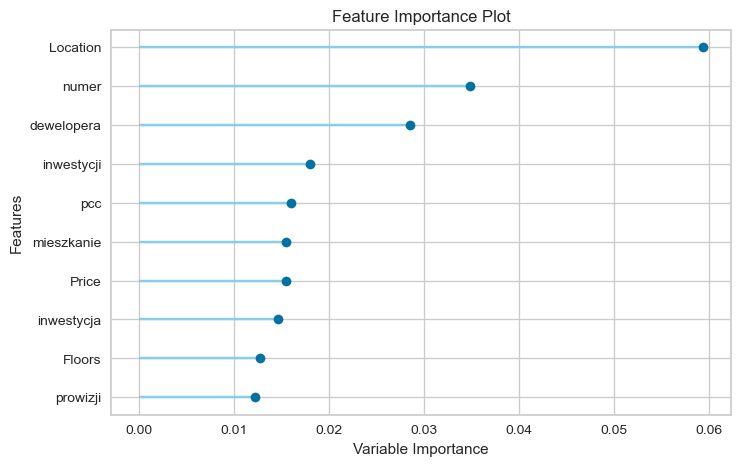

In [34]:
unbalanced_exp.plot_model(best_unbalanced_model, plot='feature')

In [36]:
tuned_model = unbalanced_exp.tune_model(best_unbalanced_model, n_iter=3, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6849,0.8723,0.6849,0.7129,0.6941,0.5269,0.5302
1,0.6998,0.8869,0.6998,0.7273,0.7085,0.5493,0.5525
2,0.6700,0.8622,0.6700,0.6966,0.6730,0.4952,0.5004
3,0.7171,0.8879,0.7171,0.7256,0.7156,0.5644,0.5687
4,0.6873,0.8843,0.6873,0.7164,0.6947,0.5327,0.5375
5,0.6940,0.8945,0.6940,0.7160,0.6990,0.5418,0.5456
6,0.6816,0.8961,0.6816,0.7279,0.6974,0.5300,0.5361
7,0.6940,0.8956,0.6940,0.7231,0.6975,0.5445,0.5524
8,0.7214,0.8883,0.7214,0.7284,0.7199,0.5762,0.5796


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 3 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [38]:
best_model = unbalanced_exp.compare_models([best_unbalanced_model, tuned_model])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Extra Trees Classifier,0.7936,0.9116,0.7936,0.7849,0.7618,0.6632,0.6820,0.1620
1,Extra Trees Classifier,0.7936,0.9116,0.7936,0.7849,0.7618,0.6632,0.6820,0.1630


Processing:   0%|          | 0/13 [00:00<?, ?it/s]

In [39]:
unbalanced_exp.predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7966,0.9187,0.7966,0.7788,0.7657,0.6693,0.6865


,Area,Price,NumberOfRooms,BuiltYear,BuildingType,Floor,Floors,Location,00,000,...,śródmieście,śródmieściu,świetna,świetnej,żoliborz,żoliborzu,życia,BuildingCondition,prediction_label,prediction_score
98570,47.000000,750000.0,2.0,1951-01-01,Kamienica,1.0,4.0,"Mazowieckie, Warszawa, Wola, Muranów, Ul. Nowo...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.54
100561,51.000000,529000.0,2.0,2003-01-01,Pozostałe,0.0,5.0,"Mazowieckie, Warszawa, Białołęka",0,1,...,0,0,0,0,0,0,0,GOOD,AFTER_RENOVATION,0.74
103449,57.000000,640000.0,2.0,NaT,Apartamentowiec,2.0,4.0,"Mazowieckie, Warszawa, Włochy, Raków, Aleje Je...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,1.00
101140,73.000000,1800000.0,3.0,2015-01-01,Blok,1.0,NaN,"Mazowieckie, Warszawa, Wola",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.91
99242,80.000000,1395000.0,3.0,1999-01-01,Blok,2.0,4.0,"Mazowieckie, Warszawa, Ochota",0,0,...,0,0,0,0,0,0,0,GOOD,AFTER_RENOVATION,0.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102651,43.430000,734000.0,2.0,2019-01-01,Apartamentowiec,0.0,5.0,"Mazowieckie, Warszawa, Wawer, Marysin Wawerski",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.65
97974,38.000000,665000.0,2.0,NaT,NaN,NaN,NaN,"Mazowieckie, Warszawa, Bemowo",2,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.61
96905,46.099998,650000.0,2.0,1974-01-01,Blok,6.0,10.0,"Mazowieckie, Warszawa, Targówek",0,0,...,0,0,0,0,0,0,0,GOOD,FOR_RENOVATION,0.43
103353,32.900002,NaN,2.0,2026-01-01,NaN,4.0,6.0,"Mazowieckie, Warszawa, Włochy, Raków, Ul. Łopu...",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00


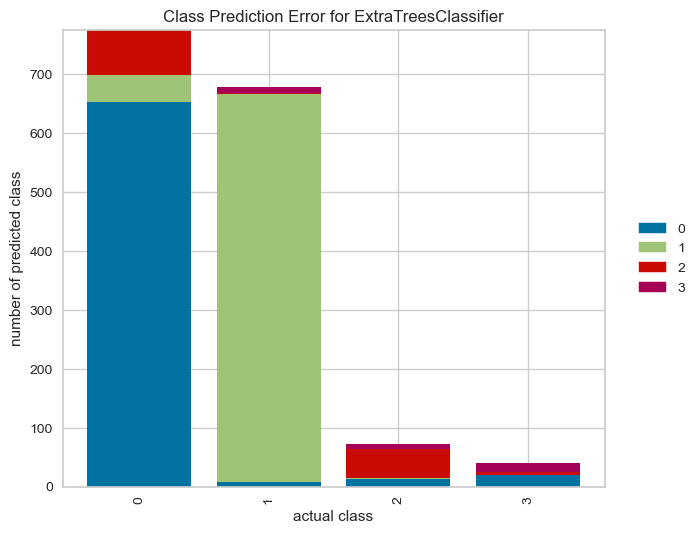

In [40]:
unbalanced_exp.plot_model(best_model, plot='error')

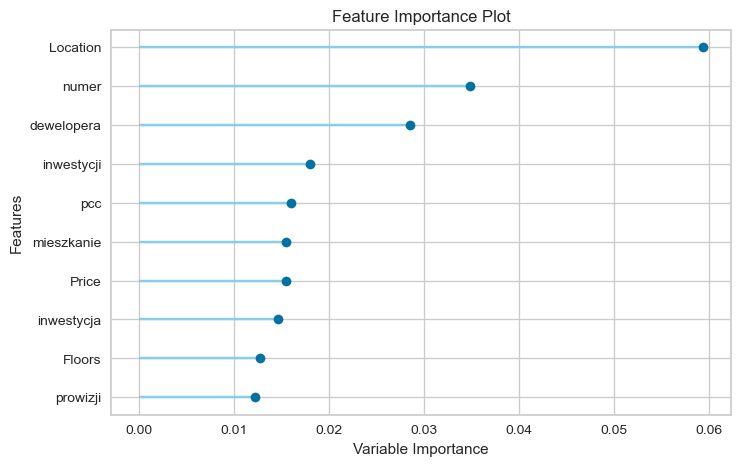

In [41]:
unbalanced_exp.plot_model(best_model, plot='feature')

In [42]:
best_tuned_model = unbalanced_exp.tune_model(
    best_model,
    optimize="F1",
    choose_better=True,
    fold=5,
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6981,0.8761,0.6981,0.7195,0.7034,0.5396,0.5430
1,0.6857,0.8745,0.6857,0.7112,0.6905,0.5242,0.5289
2,0.6944,0.8883,0.6944,0.7149,0.7002,0.5389,0.5418
3,0.6919,0.8929,0.6919,0.7278,0.7026,0.5439,0.5491
4,0.7093,0.8840,0.7093,0.7178,0.7090,0.5572,0.5604
Mean,0.6959,0.8831,0.6959,0.7182,0.7011,0.5407,0.5446
Std,0.0078,0.0070,0.0078,0.0056,0.0060,0.0106,0.0103


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [43]:
unbalanced_exp.predict_model(best_tuned_model).head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7966,0.9187,0.7966,0.7788,0.7657,0.6693,0.6865


,Area,Price,NumberOfRooms,BuiltYear,BuildingType,Floor,Floors,Location,00,000,...,śródmieście,śródmieściu,świetna,świetnej,żoliborz,żoliborzu,życia,BuildingCondition,prediction_label,prediction_score
98570,47.000000,750000.0,2.0,1951-01-01,Kamienica,1.0,4.0,"Mazowieckie, Warszawa, Wola, Muranów, Ul. Nowo...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.54
100561,51.000000,529000.0,2.0,2003-01-01,Pozostałe,0.0,5.0,"Mazowieckie, Warszawa, Białołęka",0,1,...,0,0,0,0,0,0,0,GOOD,AFTER_RENOVATION,0.74
103449,57.000000,640000.0,2.0,NaT,Apartamentowiec,2.0,4.0,"Mazowieckie, Warszawa, Włochy, Raków, Aleje Je...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,1.00
101140,73.000000,1800000.0,3.0,2015-01-01,Blok,1.0,NaN,"Mazowieckie, Warszawa, Wola",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.91
99242,80.000000,1395000.0,3.0,1999-01-01,Blok,2.0,4.0,"Mazowieckie, Warszawa, Ochota",0,0,...,0,0,0,0,0,0,0,GOOD,AFTER_RENOVATION,0.51
96830,30.000000,535000.0,1.0,1984-01-01,Blok,1.0,8.0,"Mazowieckie, Warszawa, Bemowo, Górce",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.60
99489,37.000000,512600.0,2.0,2025-01-01,Blok,1.0,2.0,"Mazowieckie, Warszawa, Białołęka, Grodzisk",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00
99140,42.799999,NaN,2.0,2026-01-01,NaN,5.0,7.0,"Mazowieckie, Warszawa, Ursus, Ul. Herbu Oksza",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00
101579,79.449997,NaN,4.0,2026-01-01,Apartamentowiec,4.0,5.0,"Mazowieckie, Warszawa, Praga-północ, Nowa Prag...",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00
96924,37.000000,494100.0,2.0,2025-01-01,Apartamentowiec,0.0,5.0,"Mazowieckie, Warszawa, Rembertów",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.70


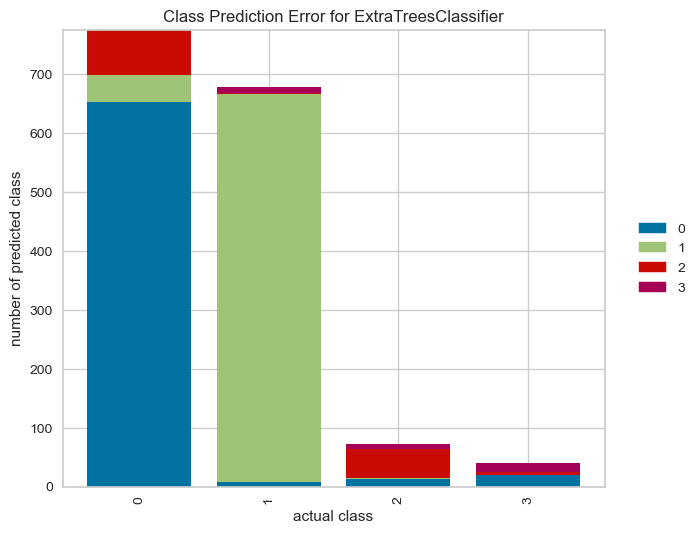

In [44]:
unbalanced_exp.plot_model(best_tuned_model, plot='error')

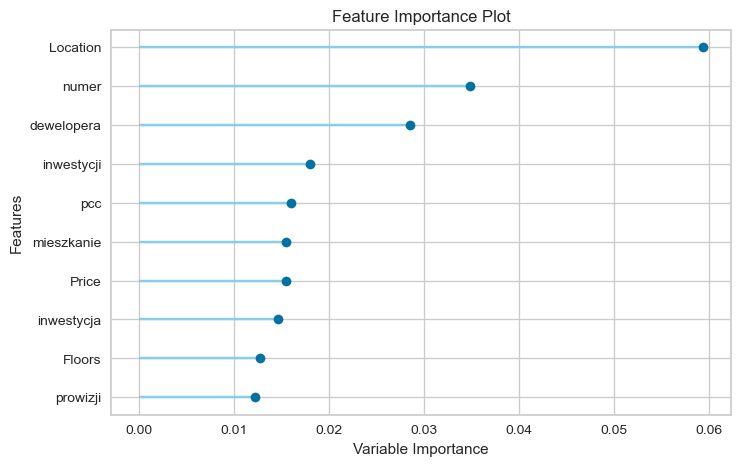

In [45]:
unbalanced_exp.plot_model(best_tuned_model, plot='feature')

In [46]:
best_final_model = unbalanced_exp.finalize_model(best_tuned_model)
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('date_feature_extractor',
                 TransformerWrapper(exclude=None, include=['BuiltYear'],
                                    transformer=ExtractDateTimeFeatures(features=['day',
                                                                                  'month',
                                                                                  'year']))),
                ('numerical_imputer',
                 TransformerWrapper(exclude=Non...
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='sqrt',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      monotonic_cst=None, n_estimators=100,
                                      n_jobs=-1, oob_score=False,
                                      random_state=1123, verbose=0,
                                      warm_start=False))],
         verbose=False)

In [48]:
unbalanced_exp.save_model(best_final_model, "best_buildingCond_modelExTreeCl_v2", verbose=False);

In [49]:
unbalanced_exp.predict_model(best_final_model).head(10)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9925,0.9981,0.9925,0.9924,0.9924,0.9884,0.9885


,Area,Price,NumberOfRooms,BuiltYear,BuildingType,Floor,Floors,Location,00,000,...,śródmieście,śródmieściu,świetna,świetnej,żoliborz,żoliborzu,życia,BuildingCondition,prediction_label,prediction_score
98570,47.000000,750000.0,2.0,1951-01-01,Kamienica,1.0,4.0,"Mazowieckie, Warszawa, Wola, Muranów, Ul. Nowo...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.94
100561,51.000000,529000.0,2.0,2003-01-01,Pozostałe,0.0,5.0,"Mazowieckie, Warszawa, Białołęka",0,1,...,0,0,0,0,0,0,0,GOOD,GOOD,0.81
103449,57.000000,640000.0,2.0,NaT,Apartamentowiec,2.0,4.0,"Mazowieckie, Warszawa, Włochy, Raków, Aleje Je...",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,1.00
101140,73.000000,1800000.0,3.0,2015-01-01,Blok,1.0,NaN,"Mazowieckie, Warszawa, Wola",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,0.93
99242,80.000000,1395000.0,3.0,1999-01-01,Blok,2.0,4.0,"Mazowieckie, Warszawa, Ochota",0,0,...,0,0,0,0,0,0,0,GOOD,GOOD,0.78
96830,30.000000,535000.0,1.0,1984-01-01,Blok,1.0,8.0,"Mazowieckie, Warszawa, Bemowo, Górce",0,0,...,0,0,0,0,0,0,0,AFTER_RENOVATION,AFTER_RENOVATION,1.00
99489,37.000000,512600.0,2.0,2025-01-01,Blok,1.0,2.0,"Mazowieckie, Warszawa, Białołęka, Grodzisk",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00
99140,42.799999,NaN,2.0,2026-01-01,NaN,5.0,7.0,"Mazowieckie, Warszawa, Ursus, Ul. Herbu Oksza",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,1.00
101579,79.449997,NaN,4.0,2026-01-01,Apartamentowiec,4.0,5.0,"Mazowieckie, Warszawa, Praga-północ, Nowa Prag...",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.98
96924,37.000000,494100.0,2.0,2025-01-01,Apartamentowiec,0.0,5.0,"Mazowieckie, Warszawa, Rembertów",0,0,...,0,0,0,0,0,0,0,DEVELOPER_STATE,DEVELOPER_STATE,0.99


In [50]:
predictions = unbalanced_exp.predict_model(best_final_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9925,0.9981,0.9925,0.9924,0.9924,0.9884,0.9885


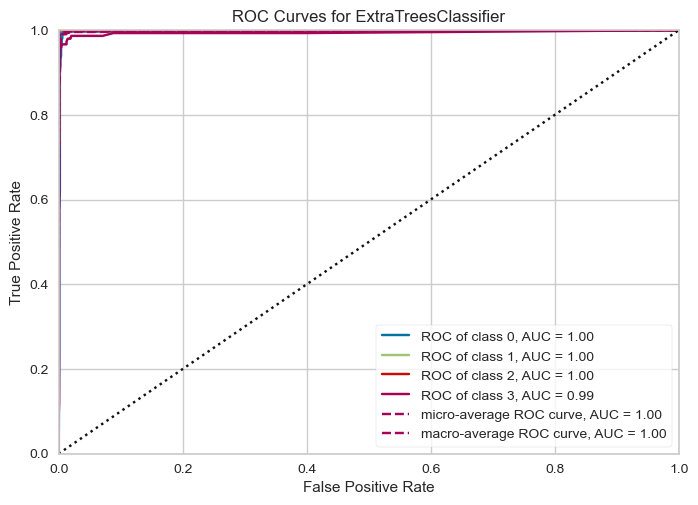

In [51]:
plot_model(best_final_model, plot="auc")

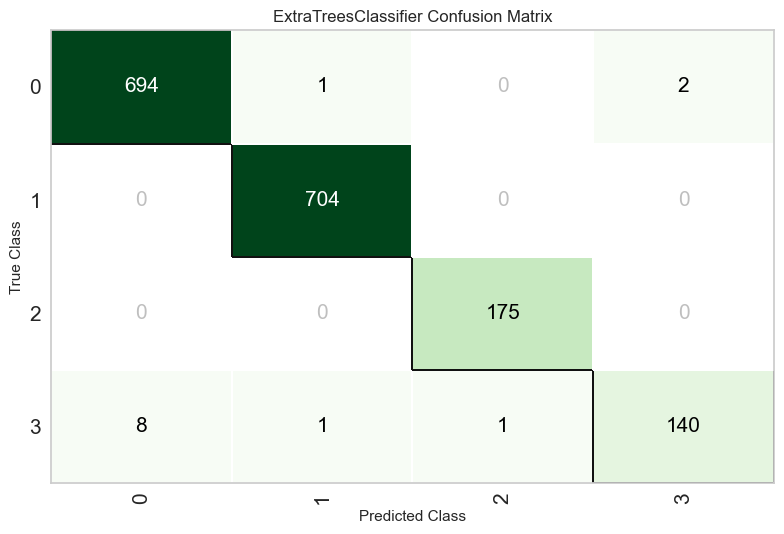

In [52]:
plot_model(best_final_model, plot="confusion_matrix")
# ile wartości z oryginalnego zbioru danych (True Class) algorytm zmienił na nową wartość po analizie(Predicted Class)
# np. 7 wartości oryginalnych o ocenie 1 zostało zmienionych na 0

## Confusion Matrix (Macierz pomyłek)

Confusion Matrix to tabela, która przedstawia liczbę poprawnych i niepoprawnych klasyfikacji dla każdej klasy. Ułatwia analizę, gdzie model popełnia błędy.

|               | Predicted Positive | Predicted Negative |
|---------------|--------------------|--------------------|
| Actual Positive | True Positive (TP)  | False Negative (FN) |
| Actual Negative | False Positive (FP) | True Negative (TN)  |
 
Analiza macierzy pomyłek pozwala zrozumieć, które klasy są mylone przez model oraz jaki jest balans między różnymi rodzajami błędów.

<span style="color:red">Idealny model miałby same wartości na przekątnej (TP i TN) oraz zera poza nią.</span>

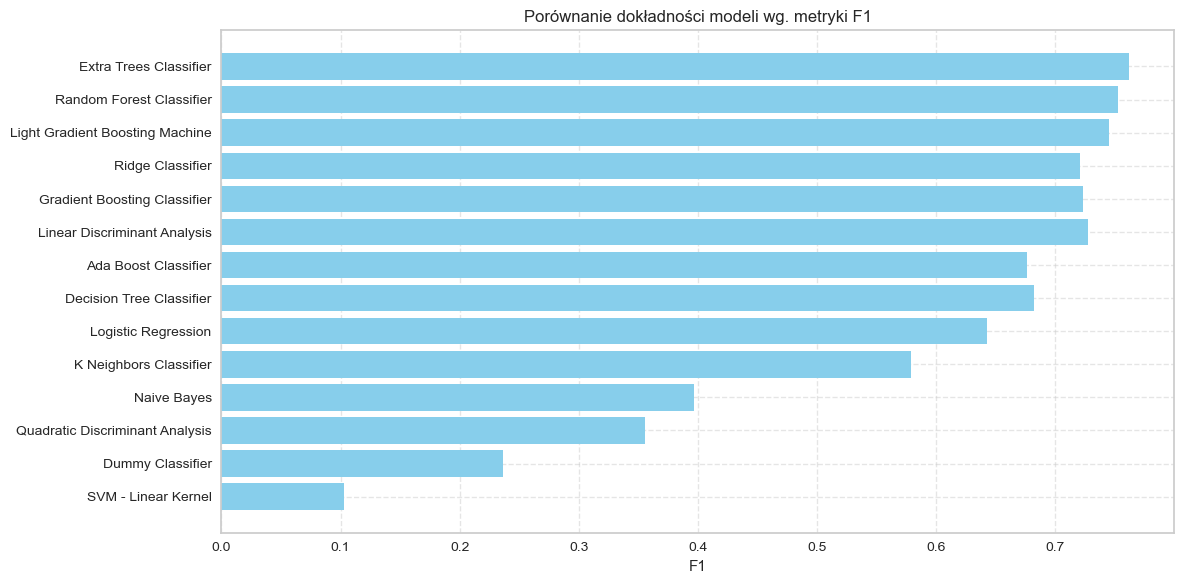

In [53]:
plt.figure(figsize=(12, 6))
plt.barh(unbalanced_metrics_df['Model'], unbalanced_metrics_df['F1'], color='skyblue')
plt.xlabel('F1')
plt.title('Porównanie dokładności modeli wg. metryki F1')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [54]:
best_final_model.get_params()

{'memory': Memory(location=None),
 'steps': [('label_encoding',
   TransformerWrapperWithInverse(exclude=None, include=None,
                                 transformer=LabelEncoder())),
  ('date_feature_extractor',
   TransformerWrapper(exclude=None, include=['BuiltYear'],
                      transformer=ExtractDateTimeFeatures(features=['day', 'month',
                                                                    'year']))),
  ('numerical_imputer',
   TransformerWrapper(exclude=None,
                      include=['Area', 'Price', 'NumberOfRooms', 'Floor', 'Floors',
                               '00', '000', '01', '02', '03', '04', '07', '10',
                               '11', '12', '13', '14', '15', '16', '17', '18',
                               '19', '20', '2024', '2025', '21', '22', '24', '25',
                               '26', ...],
                      transformer=SimpleImputer(add_indicator=False, copy=True,
                                                fil

In [55]:
predicted_column = predictions['prediction_label']
print(predicted_column)

98570     AFTER_RENOVATION
100561                GOOD
103449    AFTER_RENOVATION
101140    AFTER_RENOVATION
99242                 GOOD
                ...       
102651    AFTER_RENOVATION
97974      DEVELOPER_STATE
96905                 GOOD
103353     DEVELOPER_STATE
96585      DEVELOPER_STATE
Name: prediction_label, Length: 1726, dtype: object


In [56]:
df_last=predictions[['prediction_label','BuildingCondition', ]]

In [57]:
df_last = df_last.reset_index()  
print(df_last.columns) 

Index(['index', 'prediction_label', 'BuildingCondition'], dtype='object')


In [58]:
df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [59]:
df_last.to_csv('new_buildingcondition.csv')